In [48]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import pandas as pd

In [49]:
# Load Dataset
zip_path = './orl_faces.zip'

In [50]:
# Lists for image data and labels
images = []
labels = []

In [51]:
# Pre-processing
with zipfile.ZipFile(zip_path, 'r') as z:
    for file_info in z.infolist():
        if file_info.filename.endswith(".pgm"):  # ORL dataset images
            parts = file_info.filename.split('/')
            if len(parts) >= 2:
                label = parts[1]  # Extract label from folder name
                
                # Convert to grayscale
                with z.open(file_info.filename) as file:
                    image = Image.open(file).convert("L") 
                    images.append(np.array(image, dtype=np.float32))
                    labels.append(label)

In [52]:
# Convert images into a matrix where each row is a flattened image vector
X = np.array([img.flatten() for img in images])
y = np.array(labels)

In [53]:
# Convert labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [54]:
# Compute the mean vector (average face)
mean_face = np.mean(X, axis=0)

In [55]:
# Subtract the mean from the dataset
X_centered = X - mean_face

In [56]:
# Compute the covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

In [57]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

In [58]:
# Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [59]:
# Normalize eigenvectors using Z-score normalization
scaler = StandardScaler()
eigenvectors_normalized = scaler.fit_transform(eigenvectors)

In [60]:
# Reduce dimensionality using PCA (keeping top components)
n_components = 100  # No. of principal components to keep
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_pca = pca.fit_transform(X_centered)

In [61]:
# 10-fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
conf_matrices = []
reports = []

for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Compute standard deviation & mean for training data
    train_mean = np.mean(X_train, axis=0)
    train_std = np.std(X_train, axis=0)

    # Compute mean for test data
    test_mean = np.mean(X_test, axis=0)

    # Train Naive Bayes classifier
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    # Confusion matrix
    y_pred = clf.predict(X_test)
    conf_matrices.append(confusion_matrix(y_test, y_pred, labels=np.unique(y_encoded)))
    reports.append(classification_report(y_test, y_pred, zero_division=0))

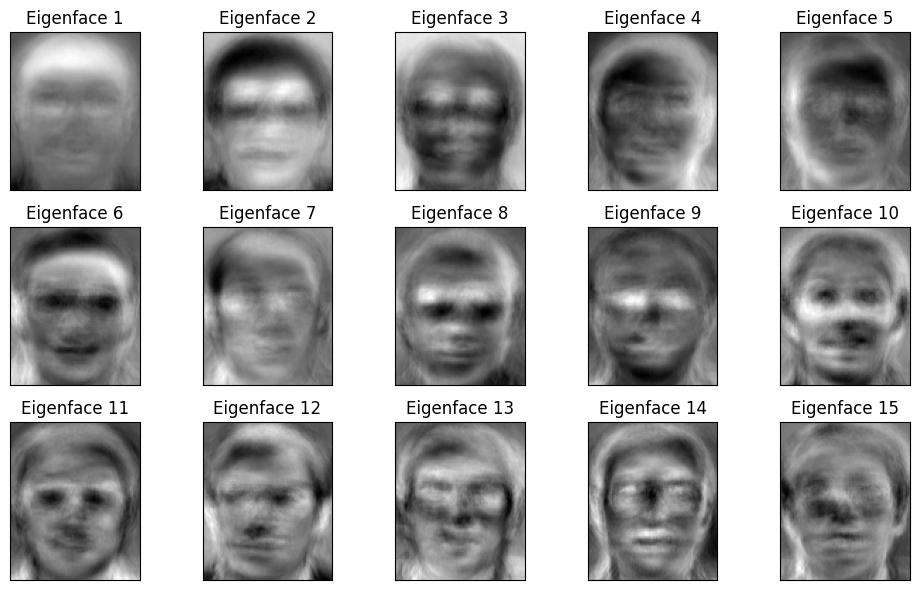

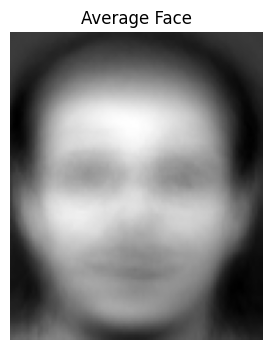

In [65]:
# Eigenfaces Visualization 
img_shape = images[0].shape
eigenfaces = pca.components_.reshape((n_components, img_shape[0], img_shape[1]))

fig, axes = plt.subplots(3, 5, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    if i < n_components:
        ax.imshow(eigenfaces[i], cmap='gray')
        ax.set_title(f"Eigenface {i+1}")
plt.tight_layout()
plt.show()

mean_face = np.mean(images, axis=0) 
plt.figure(figsize=(4, 4))
plt.imshow(mean_face.reshape(img_shape), cmap='gray')
plt.title("Average Face")
plt.axis('off')
plt.show()

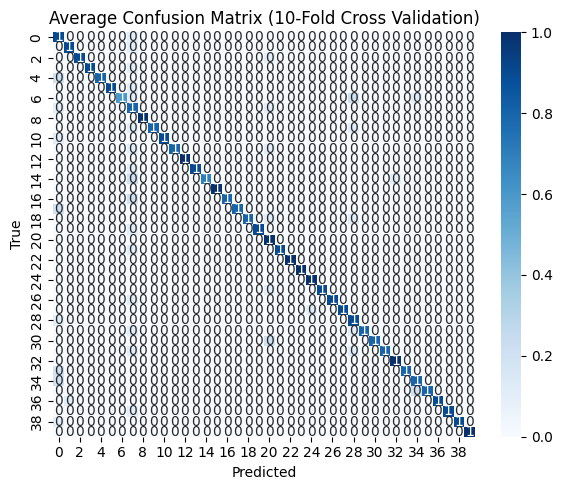


Accuracy Comparison Table:
 Principal Components  Accuracy Without Z-Score (%)  Accuracy With Z-Score (%)
                  100                          27.0                       36.5
                  500                          31.5                       44.5
                 1000                          34.0                       51.0
                 2000                          31.5                       51.5
                 5000                          43.5                       74.0
                10000                          68.0                       81.0
                15000                          71.0                       86.0
                20000                          71.5                       88.5
                22500                          69.0                       88.5

Average Classification Report (10-Fold Cross Validation):
       precision  recall  f1-score
label                             
0           0.44    0.67      0.50
1           0.75  

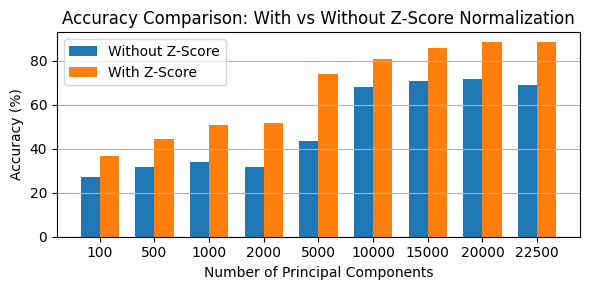

In [67]:
# Compute & display average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(6,5))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".0f", cmap="Blues")
plt.title("Average Confusion Matrix (10-Fold Cross Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Display final classification report
report_dfs = []
for report_str in reports:
    lines = report_str.split("\n")
    lines = [line.strip() for line in lines if line.strip()]
    data_lines = [line for line in lines if line[0].isdigit()]
    
    for i, line in enumerate(data_lines):
        tokens = line.split()
        if len(tokens) == 5:  # Handle standard rows
            label, prec, rec, f1, support = tokens
            report_dfs.append({
                'label': label,
                'precision': float(prec),
                'recall': float(rec),
                'f1-score': float(f1),
                'support': int(support)
            })

df_reports = pd.DataFrame(report_dfs)

df_accuracy = pd.DataFrame({
    "Principal Components": pcs,
    "Accuracy Without Z-Score (%)": accuracy_no_zscore,
    "Accuracy With Z-Score (%)": accuracy_zscore
})

# Print the table
print("\nAccuracy Comparison Table:")
print(df_accuracy.to_string(index=False))

# Group by label and average metrics
avg_report = df_reports.groupby('label')[['precision', 'recall', 'f1-score']].mean()
print("\nAverage Classification Report (10-Fold Cross Validation):")
print(avg_report.round(2))

pcs = [100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 22500]
accuracy_zscore = [36.5, 44.5, 51.0, 51.5, 74.0, 81.0, 86.0, 88.5, 88.5]
accuracy_no_zscore = [27.0, 31.5, 34.0, 31.5, 43.5, 68.0, 71.0, 71.5, 69.0]

x = np.arange(len(pcs))  # label locations
width = 0.35             # width of the bars

plt.figure(figsize=(6, 3))
plt.bar(x - width/2, accuracy_no_zscore, width, label='Without Z-Score')
plt.bar(x + width/2, accuracy_zscore, width, label='With Z-Score')

plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: With vs Without Z-Score Normalization')
plt.xticks(x, pcs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()